In [1]:
import geopandas
import shapely
import functools
import pyproj
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
sns.set()
pd.set_option("display.max_columns",250)

In [2]:
def percent_diff(num1, num2, use_abs=True):
    denom = (num1+num2)/2
    if use_abs:
        percent_diff = abs(num1 - num2) / denom * 100
    else:
        percent_diff = (num1 - num2) / denom * 100
    return round(percent_diff, 3)

In [3]:
county_name_dict = {
    1: 'Detroit',
    2: 'Wayne',
    3: 'Oakland',
    4: 'Macomb',
    5: 'Washtenaw',
    6: 'Monroe',
    7: 'St.Clair',
    8: 'Livingston'
}

## Input Data

In [4]:
syn_pop_path = r"E:\Projects\Clients\SEMCOG\Models\SEMCOG Trip Based Model (E7)\Model Runs\ABM_TEST\Input\data\persons.csv"
syn_hh_path = r"E:\Projects\Clients\SEMCOG\Models\SEMCOG Trip Based Model (E7)\Model Runs\ABM_TEST\Input\data\households.csv"
syn_per_df = pd.read_csv(syn_pop_path)
syn_hh_df = pd.read_csv(syn_hh_path)

In [5]:
census_p_path = r"../data/census/ACS_PUMS_2017_5yr_p_MI.csv"
census_p_df = pd.read_csv(census_p_path)

In [6]:
landuse_path = r"E:\Projects\Clients\SEMCOG\Models\SEMCOG Trip Based Model (E7)\Model Runs\ABM_TEST\Input\data\land_use.csv"
landuse_df = pd.read_csv(landuse_path)

In [7]:
census_puma_shp_path = r"E:\Projects\Clients\SEMCOG\Tasks\Task5_Visualizer\data\census\2017_puma_shapefile\tl_2017_26_puma10.shp"
puma_shp = geopandas.read_file(census_puma_shp_path)

In [8]:
taz_shp_path = r"E:\Projects\Clients\SEMCOG\Tasks\Task5_Visualizer\data\SHP\semcog_zones.shp"
taz_shp = geopandas.read_file(taz_shp_path)

## Coding School Level

In [9]:
syn_per_df = pd.merge(
    syn_per_df,
    syn_hh_df,
    how='left',
    on='household_id'
)

In [10]:
syn_per_df.head()

,legacy_person_id,race_id_x,age,relate,member_id,legacy_household_id_x,sex,ESR,WKHP,WKW,SCHG,MIL,household_id,person_id,legacy_household_id_y,building_id,race_id_y,age_of_head,children,persons,cars,TYPE,HINCP,ADJINC,HHT,zone_id
0,930000533,1,42,0,1,930000000,1,1.0,50.0,1.0,-9.0,4.0,1,1,930000000,7116155,1,42,3.0,5,2.0,1,110000.0,1025215,1.0,2781
1,930000534,1,45,1,2,930000000,2,6.0,-9.0,-9.0,-9.0,4.0,1,2,930000000,7116155,1,42,3.0,5,2.0,1,110000.0,1025215,1.0,2781
2,930000535,1,13,2,3,930000000,2,-9.0,-9.0,-9.0,9.0,-9.0,1,3,930000000,7116155,1,42,3.0,5,2.0,1,110000.0,1025215,1.0,2781
3,930000536,1,11,2,4,930000000,1,-9.0,-9.0,-9.0,7.0,-9.0,1,4,930000000,7116155,1,42,3.0,5,2.0,1,110000.0,1025215,1.0,2781
4,930000537,1,11,2,5,930000000,1,-9.0,-9.0,-9.0,7.0,-9.0,1,5,930000000,7116155,1,42,3.0,5,2.0,1,110000.0,1025215,1.0,2781


In [11]:
syn_per_df['gradeschool'] = syn_per_df['SCHG'].apply(lambda x: 1 if ((x >= 2) & (x <= 10)) else 0)
syn_per_df['highschool'] = syn_per_df['SCHG'].apply(lambda x: 1 if ((x >= 11) & (x <= 14)) else 0)
syn_per_df['university'] = syn_per_df['SCHG'].apply(lambda x: 1 if x >= 15 else 0)


In [12]:
syn_per_df['GQ_university'] = (syn_per_df['TYPE'].isin([2,3]) & syn_per_df['university'] == 1).astype(int)
syn_per_df['non_GQ_university'] = ((syn_per_df['TYPE'] == 1) & syn_per_df['university'] == 1).astype(int)

In [13]:
syn_per_df['TYPE'].value_counts(dropna=False)

1    4643055
3      47296
Name: TYPE, dtype: int64

In [14]:
census_p_df['gradeschool'] = census_p_df['SCHG'].apply(lambda x: 1 if ((x >= 2) & (x <= 10)) else 0)
census_p_df['highschool'] = census_p_df['SCHG'].apply(lambda x: 1 if ((x >= 11) & (x <= 14)) else 0)
census_p_df['university'] = census_p_df['SCHG'].apply(lambda x: 1 if x >= 15 else 0)

census_p_df['gradeschool_weighted'] = census_p_df['gradeschool'] * census_p_df['PWGTP']
census_p_df['highschool_weighted'] = census_p_df['highschool'] * census_p_df['PWGTP']
census_p_df['university_weighted'] = census_p_df['university'] * census_p_df['PWGTP']

##  Matching PUMAs to TAZs

Need to first get table with TAZ, PUMA, % overlap

In [15]:
inital_taz_crs = taz_shp.crs
inital_puma_crs = puma_shp.crs
print('initial taz crs:', taz_shp.crs)
print('initial puma crs:', puma_shp.crs)
taz_shp = taz_shp.to_crs("EPSG:4326")  # WGS84
puma_shp = puma_shp.to_crs("EPSG:4326")
assert taz_shp.crs == puma_shp.crs, "coordinate systems not the same!"

initial taz crs: {'init': 'epsg:4019'}
initial puma crs: {'init': 'epsg:4269'}


C:\Users\david.hensle\conda_envs\geopand_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\david.hensle\conda_envs\geopand_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [16]:
taz_shp['taz_area'] = taz_shp['geometry'].area
puma_shp['puma_area'] = puma_shp['geometry'].area
puma_shp['PUMA'] = puma_shp['PUMACE10'].apply(lambda x: int(str(x).lstrip('0')))
overlay_gdf = geopandas.overlay(taz_shp, puma_shp, how='intersection')

In [17]:
overlay_gdf['overlay_area'] = overlay_gdf['geometry'].area
overlay_gdf['percent_of_puma'] = overlay_gdf['overlay_area'] / overlay_gdf['puma_area'] * 100

In [18]:
overlay_gdf[overlay_gdf['PUMA'] == 3201]['percent_of_puma'].sum()

100.0

In [19]:
puma_taz_xwalk = overlay_gdf[['ID', 'PUMA', 'percent_of_puma']]
puma_taz_xwalk

,ID,PUMA,percent_of_puma
0,2790,2800,0.184359
1,2786,2800,0.093969
2,2787,2800,0.139633
3,2770,2800,0.564022
4,2737,2800,0.116758
...,...,...,...
3871,1889,3003,1.971273
3872,1887,3003,1.361727
3873,1888,3003,1.366034
3874,1898,3003,1.419794


#### Now multiply the puma edu counts by percent_of_puma to get taz counts

In [20]:
census_p_df.head()

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,CIT,CITWP,COW,DDRS,DEAR,DEYE,DOUT,DPHY,DRAT,DRATX,DREM,ENG,FER,GCL,GCM,GCR,HINS1,HINS2,HINS3,HINS4,HINS5,HINS6,HINS7,INTP,JWMNP,JWRIP,JWTR,LANX,MAR,MARHD,MARHM,MARHT,MARHW,MARHYP,MIG,MIL,MLPA,MLPB,MLPCD,MLPE,MLPFG,MLPH,MLPI,MLPJ,MLPK,NWAB,NWAV,NWLA,NWLK,NWRE,OIP,PAP,RELP,RETP,SCH,SCHG,SCHL,SEMP,SEX,SSIP,SSP,WAGP,WKHP,WKL,WKW,WRK,YOEP,ANC,ANC1P,ANC2P,DECADE,DIS,DRIVESP,ESP,ESR,FOD1P,FOD2P,HICOV,HISP,INDP,JWAP,JWDP,LANP,MIGPUMA,MIGSP,MSP,NAICSP,NATIVITY,NOP,OC,OCCP,PAOC,PERNP,PINCP,POBP,POVPIP,POWPUMA,POWSP,PRIVCOV,PUBCOV,QTRBIR,RAC1P,RAC2P,RAC3P,RACAIAN,RACASN,RACBLK,RACNH,RACNUM,RACPI,RACSOR,RACWHT,RC,SCIENGP,SCIENGRLP,...,FJWRIP,FJWTRP,FLANP,FLANXP,FMARP,FMARHDP,FMARHMP,FMARHTP,FMARHWP,FMARHYP,FMIGP,FMIGSP,FMILPP,FMILSP,FOCCP,FOIP,FPAP,FPERNP,FPINCP,FPOBP,FPOWSP,FPRIVCOVP,FPUBCOVP,FRACP,FRELP,FRETP,FSCHGP,FSCHLP,FSCHP,FSEMP,FSEXP,FSSIP,FSSP,FWAGP,FWKHP,FWKLP,FWKWP,FWRKP,FYOEP,PWGTP1,PWGTP2,PWGTP3,PWGTP4,PWGTP5,PWGTP6,PWGTP7,PWGTP8,PWGTP9,PWGTP10,PWGTP11,PWGTP12,PWGTP13,PWGTP14,PWGTP15,PWGTP16,PWGTP17,PWGTP18,PWGTP19,PWGTP20,PWGTP21,PWGTP22,PWGTP23,PWGTP24,PWGTP25,PWGTP26,PWGTP27,PWGTP28,PWGTP29,PWGTP30,PWGTP31,PWGTP32,PWGTP33,PWGTP34,PWGTP35,PWGTP36,PWGTP37,PWGTP38,PWGTP39,PWGTP40,PWGTP41,PWGTP42,PWGTP43,PWGTP44,PWGTP45,PWGTP46,PWGTP47,PWGTP48,PWGTP49,PWGTP50,PWGTP51,PWGTP52,PWGTP53,PWGTP54,PWGTP55,PWGTP56,PWGTP57,PWGTP58,PWGTP59,PWGTP60,PWGTP61,PWGTP62,PWGTP63,PWGTP64,PWGTP65,PWGTP66,PWGTP67,PWGTP68,PWGTP69,PWGTP70,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80,gradeschool,highschool,university,gradeschool_weighted,highschool_weighted,university_weighted
0,P,2013000000083,3,1,2907,2,26,1061971,32,37,1,NaN,1.0,2.0,2,2,2.0,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,1,2,2,2,2,2,2,2500.0,20.0,1.0,1.0,2.0,5,NaN,NaN,NaN,NaN,NaN,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.0,3.0,0.0,0.0,0,0.0,1.0,NaN,22.0,0.0,1,0.0,0.0,100000.0,50.0,1.0,1.0,1.0,NaN,1,51,999,NaN,2,1.0,NaN,1.0,6200.0,5401.0,1,1,7970.0,98.0,55.0,NaN,NaN,NaN,6.0,6211,1,NaN,0.0,3110.0,NaN,100000.0,102500.0,26,501.0,2900.0,26.0,1,2,3,1,1,1,0,0,0,0,1,0,0,1,0.0,2.0,2.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34,61,50,32,9,53,9,30,33,30,34,33,31,53,8,32,38,10,10,34,9,27,35,8,38,36,36,10,45,52,55,49,9,33,36,54,9,30,32,9,31,8,10,30,59,10,50,32,32,32,34,35,29,8,56,34,30,49,53,29,53,36,30,53,28,29,31,54,10,9,9,10,66,30,31,10,66,39,31,59,0,0,0,0,0,0
1,P,2013000000093,3,1,1001,2,26,1061971,19,58,1,NaN,1.0,2.0,2,2,2.0,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,1,2,2,2,2,2,2,0.0,15.0,1.0,1.0,2.0,2,2.0,2.0,1.0,1.0,1984.0,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.0,3.0,0.0,0.0,0,0.0,1.0,NaN,16.0,0.0,1,0.0,0.0,65000.0,40.0,1.0,1.0,1.0,NaN,1,21,999,NaN,2,1.0,NaN,1.0,NaN,NaN,1,1,5670.0,109.0,67.0,NaN,1000.0,26.0,3.0,4542,1,NaN,0.0,7330.0,NaN,65000.0,65000.0,26,501.0,1000.0,26.0,1,2,2,1,1,1,0,0,0,0,1,0,0,1,0.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,22,5,6,36,34,5,19,35,5,6,20,21,34,19,20,20,19,30,17,18,19,5,5,35,37,6,20,37,5,5,21,20,34,18,19,20,18,33,19,19,19,6,6,31,36,6,22,31,6,6,21,18,31,21,21,19,20,33,20,18,19,5,6,34,35,6,19,34,6,6,21,18,38,20,16,19,21,31,16,20,0,0,0,0,0,0
2,P,2013000000128,3,1,3002,2,26,1061971,32,60,1,NaN,NaN,2.0,2,2,2.0,2.0,NaN,NaN,1.0,NaN,NaN,2.0,NaN,NaN,1,2,1,2,2,2,2,5000.0,NaN,NaN,NaN,2.0,1,2.0,2.0,1.0,2.0,1975.0,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,2.0,2.0,3.0,33000.0,0.0,0,0.0,1.0,NaN,21.0,0.0,1,0.0,32000.0,0.0,NaN,3.0,NaN,2.0,NaN,2,22,32,NaN,1,NaN,NaN,6.0,2408.0,2407.0,1,1,NaN,NaN,NaN,NaN,2900.0,26.0,1.0,NaN,1,NaN,0.0,NaN,NaN,0.0,70000.0,56,450.0,NaN,NaN,1,1,3,1,1,1,0,0,0,0,1,0,0,1,0.0,1.0,2.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,30,9,31,55,31,55,10,29,56,49,34,31,34,32,29,9,31,58,10,9,32,8,30,55,31,57,10,34,53,54,34,34,33,32,33,9,30,59,56,53,33,50,34,9,30,10,53,31,9,10,30,34,33,31,33,53,34,9,54,54

In [21]:
census_p_puma_df = census_p_df.groupby('PUMA').agg({'gradeschool_weighted': 'sum', 'highschool_weighted': 'sum', 'university_weighted': 'sum', 'PWGTP': 'sum'}).reset_index()
puma_taz_edu_df = pd.merge(
    puma_taz_xwalk,
    census_p_puma_df,
    how='left',
    on='PUMA'
)
puma_taz_edu_df

,ID,PUMA,percent_of_puma,gradeschool_weighted,highschool_weighted,university_weighted,PWGTP
0,2790,2800,0.184359,20973,11684,10950,186911
1,2786,2800,0.093969,20973,11684,10950,186911
2,2787,2800,0.139633,20973,11684,10950,186911
3,2770,2800,0.564022,20973,11684,10950,186911
4,2737,2800,0.116758,20973,11684,10950,186911
...,...,...,...,...,...,...,...
3871,1889,3003,1.971273,12561,6579,8988,132020
3872,1887,3003,1.361727,12561,6579,8988,132020
3873,1888,3003,1.366034,12561,6579,8988,132020
3874,1898,3003,1.419794,12561,6579,8988,132020


In [22]:
puma_taz_edu_df['gradeschool_raw'] = puma_taz_edu_df['percent_of_puma'] * puma_taz_edu_df['gradeschool_weighted'] /100
puma_taz_edu_df['highschool_raw'] = puma_taz_edu_df['percent_of_puma'] * puma_taz_edu_df['highschool_weighted'] / 100
puma_taz_edu_df['university_raw'] = puma_taz_edu_df['percent_of_puma'] * puma_taz_edu_df['university_weighted'] / 100
puma_taz_edu_df['total_persons_raw'] = puma_taz_edu_df['percent_of_puma'] * puma_taz_edu_df['PWGTP'] / 100
puma_taz_edu_df['TAZ'] = puma_taz_edu_df['ID']
census_edu_by_taz = puma_taz_edu_df.groupby('TAZ').agg({'gradeschool_raw':'sum', 'highschool_raw': 'sum', 'university_raw':'sum', 'total_persons_raw': 'sum'}).reset_index()
census_edu_by_taz['total_edu_raw'] = census_edu_by_taz['gradeschool_raw'] + census_edu_by_taz['highschool_raw'] + census_edu_by_taz['university_raw']
census_edu_by_taz

,TAZ,gradeschool_raw,highschool_raw,university_raw,total_persons_raw,total_edu_raw
0,1,63.020330,30.028880,29.136494,521.557688,122.185703
1,2,126.223972,60.145106,58.357749,1044.632611,244.726827
2,3,64.982432,30.963811,30.043632,537.795954,125.989875
3,4,128.865567,61.403813,59.579020,1066.494097,249.848399
4,5,69.024348,32.889764,31.912349,571.246931,133.826461
...,...,...,...,...,...,...
2878,2893,2.142375,1.104055,0.656867,20.252679,3.903296
2879,2894,1.764732,0.909440,0.541079,16.682676,3.215250
2880,2895,1.828195,0.942145,0.560537,17.282621,3.330878
2881,2897,9.002489,4.362853,9.198778,92.028735,22.564120


In [23]:
tot_census_per = census_edu_by_taz['total_persons_raw'].sum()
tot_syn_per = len(syn_per_df)
print("Total Census Persons: ", int(tot_census_per))
print("Total Synthetic Persons: ", int(tot_syn_per))
print("Percent Difference: ", percent_diff(tot_census_per, tot_syn_per), '%')

Total Census Persons:  4456098
Total Synthetic Persons:  4690351
Percent Difference:  5.122 %


Need to scale the census data to match total population in synthetic population

In [24]:
scaling_factor = tot_syn_per / tot_census_per
print("scaling census data by:", scaling_factor)
puma_taz_edu_df['gradeschool'] = puma_taz_edu_df['gradeschool_raw'] * scaling_factor
puma_taz_edu_df['highschool'] = puma_taz_edu_df['highschool_raw'] * scaling_factor
puma_taz_edu_df['university'] = puma_taz_edu_df['university_raw'] * scaling_factor
puma_taz_edu_df['total_persons'] = puma_taz_edu_df['total_persons_raw'] * scaling_factor
puma_taz_edu_df['TAZ'] = puma_taz_edu_df['ID']
census_edu_by_taz_scaled = puma_taz_edu_df.groupby('TAZ').agg({'gradeschool':'sum', 'highschool': 'sum', 'university':'sum', 'total_persons': 'sum'}).reset_index()
census_edu_by_taz_scaled['total_edu'] = census_edu_by_taz_scaled['gradeschool'] + census_edu_by_taz_scaled['highschool'] + census_edu_by_taz_scaled['university']
census_edu_by_taz_scaled

scaling census data by: 1.0525688511742475


,TAZ,gradeschool,highschool,university,total_persons,total_edu
0,1,66.333237,31.607463,30.668166,548.975377,128.608865
1,2,132.859421,63.306865,61.425549,1099.547748,257.591835
2,3,68.398484,32.591543,31.622991,566.067270,132.613018
3,4,135.639881,64.631741,62.711021,1122.558467,262.982642
4,5,72.652878,34.618741,33.589945,601.276726,140.861565
...,...,...,...,...,...,...
2878,2893,2.254997,1.162094,0.691398,21.317339,4.108488
2879,2894,1.857502,0.957248,0.569523,17.559665,3.384272
2880,2895,1.924301,0.991672,0.590004,18.191149,3.505978
2881,2897,9.475739,4.592203,9.682347,96.866580,23.750290


In [25]:
scaled_census_per = census_edu_by_taz_scaled['total_persons'].sum()
tot_syn_per = len(syn_per_df)
print("Scaled Census Persons: ", int(scaled_census_per))
print("Total Synthetic Persons: ", int(tot_syn_per))
print("Percent Difference: ", percent_diff(scaled_census_per, tot_syn_per), '%')

Scaled Census Persons:  4690351
Total Synthetic Persons:  4690351
Percent Difference:  0.0 %


## EDU for each TAZ by source

In [26]:
syn_per_df['TAZ'] = syn_per_df['zone_id']
syn_edu_by_taz = syn_per_df.groupby('TAZ').agg(
    {'gradeschool': 'sum',
     'highschool': 'sum',
     'university': 'sum',
     'GQ_university': 'sum'}
).reset_index()
syn_edu_by_taz['total_edu'] = syn_edu_by_taz['gradeschool'] + syn_edu_by_taz['highschool'] + syn_edu_by_taz['university']
syn_edu_by_taz

,TAZ,gradeschool,highschool,university,GQ_university,total_edu
0,2,344,196,138,0,678
1,3,0,0,0,0,0
2,4,233,159,104,0,496
3,5,13,11,1,0,25
4,6,130,76,55,5,261
...,...,...,...,...,...,...
2667,2807,104,53,43,0,200
2668,2808,149,60,54,0,263
2669,2809,123,46,50,0,219
2670,2810,265,150,119,0,534


In [27]:
landuse_edu_by_taz = landuse_df[['ZONE', 'K_8', 'G9-12', 'Univ_Enrollment', 'COUNTY']].rename(columns={'ZONE':'TAZ'})
landuse_edu_by_taz['total_enrollment'] = landuse_edu_by_taz['K_8'] + landuse_edu_by_taz['G9-12'] + landuse_edu_by_taz['Univ_Enrollment']
landuse_edu_by_taz

,TAZ,K_8,G9-12,Univ_Enrollment,COUNTY,total_enrollment
0,1,0.0,0.0,0.0,1,0.0
1,2,0.0,0.0,0.0,1,0.0
2,3,0.0,0.0,0.0,1,0.0
3,4,535.0,0.0,0.0,1,535.0
4,5,0.0,0.0,0.0,1,0.0
...,...,...,...,...,...,...
2806,2807,0.0,0.0,0.0,8,0.0
2807,2808,0.0,0.0,0.0,8,0.0
2808,2809,0.0,0.0,0.0,8,0.0
2809,2810,0.0,0.0,0.0,8,0.0


In [28]:
census_syn_edu_by_taz = pd.merge(
    census_edu_by_taz_scaled,
    syn_edu_by_taz,
    how='outer',
    on='TAZ',
    suffixes=('_census_imputed', '_syn_pop'),
).fillna(0)
census_syn_edu_by_taz

,TAZ,gradeschool_census_imputed,highschool_census_imputed,university_census_imputed,total_persons,total_edu_census_imputed,gradeschool_syn_pop,highschool_syn_pop,university_syn_pop,GQ_university,total_edu_syn_pop
0,1,66.333237,31.607463,30.668166,548.975377,128.608865,0.0,0.0,0.0,0.0,0.0
1,2,132.859421,63.306865,61.425549,1099.547748,257.591835,344.0,196.0,138.0,0.0,678.0
2,3,68.398484,32.591543,31.622991,566.067270,132.613018,0.0,0.0,0.0,0.0,0.0
3,4,135.639881,64.631741,62.711021,1122.558467,262.982642,233.0,159.0,104.0,0.0,496.0
4,5,72.652878,34.618741,33.589945,601.276726,140.861565,13.0,11.0,1.0,0.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...
2878,2893,2.254997,1.162094,0.691398,21.317339,4.108488,0.0,0.0,0.0,0.0,0.0
2879,2894,1.857502,0.957248,0.569523,17.559665,3.384272,0.0,0.0,0.0,0.0,0.0
2880,2895,1.924301,0.991672,0.590004,18.191149,3.505978,0.0,0.0,0.0,0.0,0.0
2881,2897,9.475739,4.592203,9.682347,96.866580,23.750290,0.0,0.0,0.0,0.0,0.0


In [29]:
all_edu_by_taz = pd.merge(
    census_syn_edu_by_taz,
    landuse_edu_by_taz,
    how='outer',
    on='TAZ'
).fillna(0)
all_edu_by_taz

,TAZ,gradeschool_census_imputed,highschool_census_imputed,university_census_imputed,total_persons,total_edu_census_imputed,gradeschool_syn_pop,highschool_syn_pop,university_syn_pop,GQ_university,total_edu_syn_pop,K_8,G9-12,Univ_Enrollment,COUNTY,total_enrollment
0,1,66.333237,31.607463,30.668166,548.975377,128.608865,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,132.859421,63.306865,61.425549,1099.547748,257.591835,344.0,196.0,138.0,0.0,678.0,0.0,0.0,0.0,1.0,0.0
2,3,68.398484,32.591543,31.622991,566.067270,132.613018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4,135.639881,64.631741,62.711021,1122.558467,262.982642,233.0,159.0,104.0,0.0,496.0,535.0,0.0,0.0,1.0,535.0
4,5,72.652878,34.618741,33.589945,601.276726,140.861565,13.0,11.0,1.0,0.0,25.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2878,2893,2.254997,1.162094,0.691398,21.317339,4.108488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2879,2894,1.857502,0.957248,0.569523,17.559665,3.384272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2880,2895,1.924301,0.991672,0.590004,18.191149,3.505978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2881,2897,9.475739,4.592203,9.682347,96.866580,23.750290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
all_edu_by_taz.to_csv('../data/education_spatial_distribution/all_edu_by_taz.csv', index=False)

## Totals

In [31]:
syn_edu_by_taz['gradeschool'].sum()

554064

In [32]:
syn_edu_by_taz.sum() - census_edu_by_taz.sum()

GQ_university             NaN
TAZ                 -346738.0
gradeschool               NaN
gradeschool_raw           NaN
highschool                NaN
highschool_raw            NaN
total_edu                 NaN
total_edu_raw             NaN
total_persons_raw         NaN
university                NaN
university_raw            NaN
dtype: float64

In [33]:
syn_edu_tot = pd.DataFrame(syn_edu_by_taz.sum(), columns=['counts']).reset_index()
syn_edu_tot['source'] = 'Synthetic Population'
syn_edu_tot

,index,counts,source
0,TAZ,3811558,Synthetic Population
1,gradeschool,554064,Synthetic Population
2,highschool,274792,Synthetic Population
3,university,378137,Synthetic Population
4,GQ_university,27784,Synthetic Population
5,total_edu,1206993,Synthetic Population


In [34]:
census_edu_tot = pd.DataFrame(census_edu_by_taz_scaled.sum(), columns=['counts']).reset_index()
census_edu_tot['source'] = 'Census PUMS'
census_edu_tot

,index,counts,source
0,TAZ,4.158296e+06,Census PUMS
1,gradeschool,5.244772e+05,Census PUMS
2,highschool,2.603719e+05,Census PUMS
3,university,3.593159e+05,Census PUMS
4,total_persons,4.690351e+06,Census PUMS
5,total_edu,1.144165e+06,Census PUMS


In [35]:
landuse_df['gradeschool'] = landuse_df['K_8']
landuse_df['highschool'] = landuse_df['G9-12']
landuse_df['university'] = landuse_df['Univ_Enrollment']
landuse_df['total_edu'] = landuse_df['gradeschool'] + landuse_df['highschool'] + landuse_df['university']

landuse_tot = pd.DataFrame(landuse_df[['gradeschool', 'highschool', 'university', 'total_edu']].sum(), columns=['counts']).reset_index()
landuse_tot['source'] = 'Landuse Enrollment'
landuse_tot

,index,counts,source
0,gradeschool,460313.0,Landuse Enrollment
1,highschool,211511.0,Landuse Enrollment
2,university,248962.0,Landuse Enrollment
3,total_edu,920786.0,Landuse Enrollment


In [36]:
edu_tot = pd.concat([syn_edu_tot, census_edu_tot, landuse_tot], axis=0)
edu_tot

,index,counts,source
0,TAZ,3.811558e+06,Synthetic Population
1,gradeschool,5.540640e+05,Synthetic Population
2,highschool,2.747920e+05,Synthetic Population
3,university,3.781370e+05,Synthetic Population
4,GQ_university,2.778400e+04,Synthetic Population
5,total_edu,1.206993e+06,Synthetic Population
0,TAZ,4.158296e+06,Census PUMS
1,gradeschool,5.244772e+05,Census PUMS
2,highschool,2.603719e+05,Census PUMS
3,university,3.593159e+05,Census PUMS


In [37]:
edu_tot = edu_tot[edu_tot['index'].isin(['gradeschool', 'highschool', 'university', 'total_edu'])]

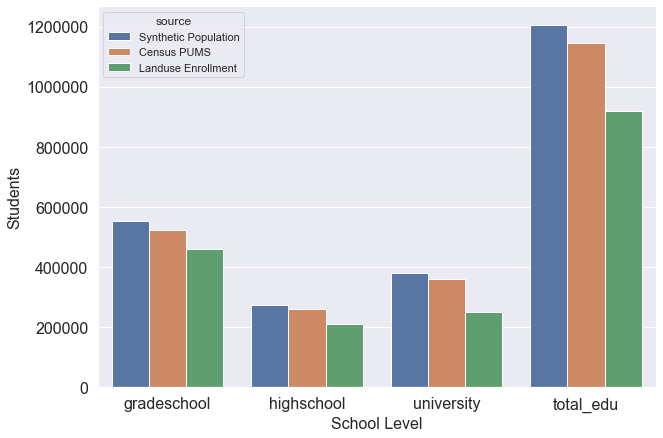

In [38]:
plt.figure(figsize=(10,7))
sns.barplot(data=edu_tot, x='index', y='counts', hue='source')
plt.xlabel('School Level', size=16)
plt.ylabel('Students', size=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [39]:
tot_census_per = census_edu_by_taz_scaled['total_persons'].sum()
tot_syn_per = len(syn_per_df)
print("Total Census Persons: ", int(tot_census_per))
print("Total Synthetic Persons: ", int(tot_syn_per))
print("Percent Difference: ", percent_diff(tot_census_per,tot_syn_per) , '%')

Total Census Persons:  4690351
Total Synthetic Persons:  4690351
Percent Difference:  0.0 %


In [40]:
total_landuse_enrollment = int(landuse_df['Univ_Enrollment'].sum())
total_syn_pop_univ_students = int(all_edu_by_taz['university_syn_pop'].sum())
print("Total landuse university enrollment: ", total_landuse_enrollment)
print("Total synthetic population university students: ", total_syn_pop_univ_students)
print("percent difference: ", percent_diff(total_landuse_enrollment, total_syn_pop_univ_students),'%')

Total landuse university enrollment:  248962
Total synthetic population university students:  378137
percent difference:  41.198 %


In [41]:
tot_univ = syn_per_df['university'].sum()
GQ_univ = syn_per_df['GQ_university'].sum()
non_GQ_univ = syn_per_df['non_GQ_university'].sum()
print('Synthetic Population')
print('total university students: ', tot_univ)
print('Number of students living in Group Quarters: ', GQ_univ)
print('Number of students not living in Group Quarters:', non_GQ_univ)
print('GQ + non_GQ (check for consistency): ', GQ_univ + non_GQ_univ)
print("portion of GQ (GQ_univ/tot_univ): ", round(GQ_univ / tot_univ, 4))

Synthetic Population
total university students:  378137
Number of students living in Group Quarters:  27784
Number of students not living in Group Quarters: 350353
GQ + non_GQ (check for consistency):  378137
portion of GQ (GQ_univ/tot_univ):  0.0735


## Land use vs Syn Pop for university students by County

In [42]:
all_edu_by_county = all_edu_by_taz.groupby(['COUNTY']).sum().drop(columns='TAZ').drop(index=0.0)
all_edu_by_county['landuse_syn_pop_univ_per_diff'] = all_edu_by_county.apply(lambda row: percent_diff(row['Univ_Enrollment'], row['university_syn_pop'], use_abs=False), axis=1)
all_edu_by_county = all_edu_by_county.reset_index()
all_edu_by_county['county_name'] = all_edu_by_county['COUNTY'].apply(lambda x: county_name_dict[x])
all_edu_by_county = all_edu_by_county.set_index('COUNTY')
output_table = all_edu_by_county[['county_name','Univ_Enrollment', 'university_syn_pop', 'landuse_syn_pop_univ_per_diff']]
output_table.loc['total'] = ['Total', total_landuse_enrollment, total_syn_pop_univ_students, percent_diff(total_landuse_enrollment, total_syn_pop_univ_students, use_abs=False)]
output_table

C:\Users\david.hensle\conda_envs\geopand_env\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,county_name,Univ_Enrollment,university_syn_pop,landuse_syn_pop_univ_per_diff
COUNTY,,,,
1.0,Detroit,46710.0,50034.0,-6.872
2.0,Wayne,42099.0,77509.0,-59.210
3.0,Oakland,51319.0,91802.0,-56.572
4.0,Macomb,22914.0,60488.0,-90.103
5.0,Washtenaw,78311.0,71192.0,9.524
6.0,Monroe,3482.0,7683.0,-75.253
7.0,St.Clair,4127.0,8953.0,-73.792
8.0,Livingston,0.0,10476.0,-200.000
total,Total,248962.0,378137.0,-41.198


## Ann Arbor (Washtenaw County)

In [43]:
# all_edu_by_taz_county = pd.merge(
#     all_edu_by_taz,
#     landuse_df[['ZONE', 'COUNTY']].rename(columns={'ZONE': 'TAZ'}),
#     how='left',
#     on='TAZ'
# )

In [44]:
all_edu_by_taz_wash = all_edu_by_taz[all_edu_by_taz['COUNTY'] == 5]
tot_wash_univ_syn_pop = all_edu_by_taz_wash['university_syn_pop'].sum()
tot_wash_univ_enrollment = all_edu_by_taz_wash['Univ_Enrollment'].sum()


In [45]:
# washtenaw community college taz 2343
washtenaw_community_enrollment = 12354  # 2017 total enrollment
landuse_wash_comm_univ_enroll = landuse_df.loc[landuse_df['ZONE'] == 2343,'Univ_Enrollment'].values[0]
print("Washtenaw Community College land-use enrollment:", landuse_wash_comm_univ_enroll)
print('Washtenaw Community College googled 2017 enrollment: ', washtenaw_community_enrollment)
print("percent difference: ", percent_diff(landuse_wash_comm_univ_enroll, washtenaw_community_enrollment, use_abs=False), '%')
print('\n')

# eastern michigan taz 2074
eastern_michigan_enrollment = 21105  # 2017 total enrollment
landuse_eastern_mich_univ_enroll = landuse_df.loc[landuse_df['ZONE'] == 2074,'Univ_Enrollment'].values[0]
print("Eastern Michigan University land-use enrollment:", landuse_eastern_mich_univ_enroll)
print('Eastern Michigan University googled 2017 enrollment: ', eastern_michigan_enrollment)
print("percent difference: ", percent_diff(landuse_eastern_mich_univ_enroll, eastern_michigan_enrollment, use_abs=False), '%')
print('\n')

# university of michigan is all the other land use in washtenaw
univ_mich_enrollment = 44718  # 2016 total enrollment
landuse_umich_univ_enroll = tot_wash_univ_enrollment - landuse_wash_comm_univ_enroll - landuse_eastern_mich_univ_enroll
print("University of Michigan land-use enrollment:", landuse_umich_univ_enroll)
print('University of Michigan googled 2016 enrollment: ', univ_mich_enrollment)
print('landuse - googled enrollment: ', landuse_wash_comm_univ_enroll - washtenaw_community_enrollment)
print("percent difference: ", percent_diff(landuse_umich_univ_enroll, univ_mich_enrollment, use_abs=False), '%')
print('\n')

# total Washtenaw County (COUNTY==5)
landuse_wash_county_univ_enroll = landuse_df.loc[landuse_df['COUNTY'] == 5,'Univ_Enrollment'].sum()
expected_wash_univ_enrollment = univ_mich_enrollment + eastern_michigan_enrollment + washtenaw_community_enrollment
print("Washtenaw County land-use enrollment: ", landuse_wash_county_univ_enroll)
print('Sum of Washtenaw Comm College, UofM, and EM googled enrollment: ', expected_wash_univ_enrollment)
print('landuse - googled enrollment: ', landuse_wash_comm_univ_enroll - washtenaw_community_enrollment)
print("percent difference: ", percent_diff(landuse_wash_county_univ_enroll, expected_wash_univ_enrollment, use_abs=False), '%')
print('\n')

# Compared to Synthetic Population:
print("Washtenaw County synthetic population university students: ", tot_wash_univ_syn_pop)
print("percent difference from landuse enrollment: ", percent_diff(landuse_wash_county_univ_enroll, tot_wash_univ_syn_pop, use_abs=False), '%')

Washtenaw Community College land-use enrollment: 12295.0
Washtenaw Community College googled 2017 enrollment:  12354
percent difference:  -0.479 %


Eastern Michigan University land-use enrollment: 22401.0
Eastern Michigan University googled 2017 enrollment:  21105
percent difference:  5.958 %


University of Michigan land-use enrollment: 43615.0
University of Michigan googled 2016 enrollment:  44718
landuse - googled enrollment:  -59.0
percent difference:  -2.497 %


Washtenaw County land-use enrollment:  78311.0
Sum of Washtenaw Comm College, UofM, and EM googled enrollment:  78177
landuse - googled enrollment:  -59.0
percent difference:  0.171 %


Washtenaw County synthetic population university students:  71192.0
percent difference from landuse enrollment:  9.524 %


### Looking at 1, 3, and 5 mile buffers around the UMich campus

In [46]:
taz_shp.head()

,ID,AREA,COUNTY,EXTERNAL,DISTRICT,SUPER_DIST,geometry,taz_area
0,2790,1.077370,8,0,244,14.0,"POLYGON ((-83.92963 42.60719, -83.93015 42.606...",0.000307
1,2786,0.549209,8,0,244,14.0,"POLYGON ((-83.93365 42.60023, -83.93364 42.600...",0.000156
2,2787,0.815927,8,0,244,14.0,"POLYGON ((-83.91439 42.60155, -83.91709 42.602...",0.000232
3,2770,3.295770,8,0,245,14.0,"POLYGON ((-83.91431 42.60027, -83.91432 42.600...",0.000938
4,2737,0.682500,8,0,243,14.0,"POLYGON ((-83.91431 42.59998, -83.91431 42.600...",0.000194


In [47]:
def create_circle(radius, lat, lon):
    local_azimuthal_projection = "+proj=aeqd +R=6371000 +units=m +lat_0={} +lon_0={}".format(
        lat, lon
    )
    wgs84_to_aeqd = functools.partial(
        pyproj.transform,
        pyproj.Proj("+proj=longlat +datum=WGS84 +no_defs"),
        pyproj.Proj(local_azimuthal_projection),
    )
    aeqd_to_wgs84 = functools.partial(
        pyproj.transform,
        pyproj.Proj(local_azimuthal_projection),
        pyproj.Proj("+proj=longlat +datum=WGS84 +no_defs"),
    )

    center = shapely.geometry.Point(float(lon), float(lat))
    point_transformed = shapely.ops.transform(wgs84_to_aeqd, center)
    buffer = point_transformed.buffer(radius)
    # Get the polygon with lat lon coordinates
    circle_poly = shapely.ops.transform(aeqd_to_wgs84, buffer)
    return circle_poly

umich_center = taz_shp.loc[taz_shp['ID'] == 2152, 'geometry'].centroid
umich_lon, umich_lat = umich_center.x.values[0], umich_center.y.values[0]
meters_per_mile = 1609.34
one_mile_circle = create_circle(1*meters_per_mile, umich_lat, umich_lon)
three_mile_circle = create_circle(3*meters_per_mile, umich_lat, umich_lon)
five_mile_circle = create_circle(5*meters_per_mile, umich_lat, umich_lon)

In [48]:
circles_df = pd.DataFrame(columns=['radius[mi]','geometry'])
circles_df = circles_df.append({'radius[mi]':1, 'geometry': one_mile_circle}, ignore_index=True)
circles_df = circles_df.append({'radius[mi]':3, 'geometry': three_mile_circle}, ignore_index=True)
circles_df = circles_df.append({'radius[mi]':5, 'geometry': five_mile_circle}, ignore_index=True)
circles_df

,radius[mi],geometry
0,1,"POLYGON ((-83.7175785326683 42.27666575307405,..."
1,3,POLYGON ((-83.67845692388248 42.27665245723907...
2,5,"POLYGON ((-83.63933533985849 42.2766258655809,..."


In [49]:
circles_gdf = geopandas.GeoDataFrame(circles_df, geometry='geometry')
circles_gdf.crs = taz_shp.crs
circles_gdf.to_crs("EPSG:4326") 
try:
    circles_gdf.to_file('../data/education_spatial_distribution/UM_circles.shp')
except:
    print('WARNING: shapefile not saved. Old version likely in use.')
    pass

In [50]:
circle_overlay = geopandas.overlay(taz_shp, circles_gdf, how='intersection')
circle_xwalk = circle_overlay[['ID', 'radius[mi]']].rename(columns={'ID':'TAZ'})
circle_xwalk

,TAZ,radius[mi]
0,2289,5
1,2290,5
2,2356,5
3,2373,5
4,2372,5
...,...,...
387,2135,1
388,2123,1
389,2133,1
390,2132,1


In [51]:
edu_taz_in_circles_df = pd.merge(
    circle_xwalk,
    all_edu_by_taz,
    how='left',
    on='TAZ'
)

In [52]:
edu_circles = edu_taz_in_circles_df.groupby('radius[mi]').sum()[['university_syn_pop', 'GQ_university', 'Univ_Enrollment']]
edu_circles['GQ [%]'] = round(edu_circles['GQ_university'] / edu_circles['university_syn_pop'] * 100, 2)
edu_circles['Enrollment - Univ Syn Pop [%]'] = edu_circles.apply(lambda row: 
    percent_diff(row['Univ_Enrollment'], row['university_syn_pop'], use_abs=True), axis=1)
edu_circles

,university_syn_pop,GQ_university,Univ_Enrollment,GQ [%],Enrollment - Univ Syn Pop [%]
radius[mi],,,,,
1,29202.0,12034.0,31995.0,41.21,9.128
3,44014.0,13502.0,55910.0,30.68,23.810
5,50445.0,13695.0,55910.0,27.15,10.277


## Other Large Universities

In [53]:
# U of M dearborn taz 450
um_dearborn_enrollment = 9195   # from website
landuse_um_dearborn_univ_enroll = landuse_df.loc[landuse_df['ZONE'] == 450,'Univ_Enrollment'].values[0]
print("University of Michigan - Dearborn land-use enrollment:", landuse_um_dearborn_univ_enroll)
print('University of Michigan - Dearborn googled 2017 enrollment: ', um_dearborn_enrollment)
print("percent difference: ", percent_diff(landuse_um_dearborn_univ_enroll, um_dearborn_enrollment, use_abs=False), '%')
print('\n')

# University of Detroit Mercy tazs 323, 330, 336
detroit_mercy_enrollment = 4902   # 2015 enrollment
landuse_detroit_mercy_univ_enroll = landuse_df.loc[landuse_df['ZONE'].isin([323, 330, 336]),'Univ_Enrollment'].values[0]
print("University of Detroit Mercy land-use enrollment:", landuse_detroit_mercy_univ_enroll)
print('University of Detroit Mercy googled 2017 enrollment: ', detroit_mercy_enrollment)
print("percent difference: ", percent_diff(landuse_detroit_mercy_univ_enroll, detroit_mercy_enrollment, use_abs=False), '%')
print('\n')

# Wayne State University tazs 175, 176, 198
detroit_mercy_enrollment = 27222   # 2015 enrollment
landuse_detroit_mercy_univ_enroll = landuse_df.loc[landuse_df['ZONE'].isin([175, 176, 198]),'Univ_Enrollment'].values[0]
print("Wayne State University land-use enrollment:", landuse_detroit_mercy_univ_enroll)
print('Wayne State University googled 2017 enrollment: ', detroit_mercy_enrollment)
print("percent difference: ", percent_diff(landuse_detroit_mercy_univ_enroll, detroit_mercy_enrollment, use_abs=False), '%')
print('\n')

University of Michigan - Dearborn land-use enrollment: 22713.0
University of Michigan - Dearborn googled 2017 enrollment:  9195
percent difference:  84.731 %


University of Detroit Mercy land-use enrollment: 1774.0
University of Detroit Mercy googled 2017 enrollment:  4902
percent difference:  -93.709 %


Wayne State University land-use enrollment: 20163.0
Wayne State University googled 2017 enrollment:  27222
percent difference:  -29.794 %


